In [1]:
spark

In [3]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, min, max, avg, stddev
import matplotlib.pyplot as plt
import pandas as pd

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Flight Price EDA") \
    .getOrCreate()

source_bucket_name = 'gs://my-bigdata-project-es/landing'
source_file_path = f"{source_bucket_name}/itineraries.csv"
output_bucket_name = 'gs://my-my-bigdata-project-es/cleaned'

sdf = spark.read.options(header='true', inferschema='true').csv(source_file_path)

sdf.count()

24/10/24 02:41:45 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


82138753

In [4]:
#List of columns
print(f"Columns: {sdf.columns}")


Columns: ['legId', 'searchDate', 'flightDate', 'startingAirport', 'destinationAirport', 'fareBasisCode', 'travelDuration', 'elapsedDays', 'isBasicEconomy', 'isRefundable', 'isNonStop', 'baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance', 'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsEquipmentDescription', 'segmentsDurationInSeconds', 'segmentsDistance', 'segmentsCabinCode']


In [6]:
from pyspark.sql.functions import isnan, col, when, count

# Separate numeric and non-numeric columns
numeric_columns = [c for c, t in sdf.dtypes if t in ['int', 'double', 'float']]
non_numeric_columns = [c for c, t in sdf.dtypes if t not in ['int', 'double', 'float']]

# Count missing values for numeric columns using `isnan()` and for non-numeric columns using `isNull()`
missing_values_numeric = sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_columns])
missing_values_non_numeric = sdf.select([count(when(col(c).isNull(), c)).alias(c) for c in non_numeric_columns])

# Show missing values for both numeric and non-numeric columns
print("Missing values in numeric columns:")
missing_values_numeric.show()

print("Missing values in non-numeric columns:")
missing_values_non_numeric.show()


Missing values in numeric columns:


+-----------+--------+---------+--------------+-------------------+
|elapsedDays|baseFare|totalFare|seatsRemaining|totalTravelDistance|
+-----------+--------+---------+--------------+-------------------+
|          0|       0|        0|             0|            6094532|
+-----------+--------+---------+--------------+-------------------+

Missing values in non-numeric columns:


+-----+----------+----------+---------------+------------------+-------------+--------------+--------------+------------+---------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|isBasicEconomy|isRefundable|isNonStop|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDistance|segmentsCabinCode|
+-----+----------+----------+---------------+------------------+-------------+--------------+--------------+------------+---------+-----

In [9]:
from pyspark.sql.functions import col, min, max, avg, stddev

# Select numeric columns
numeric_columns = [c for c, t in sdf.dtypes if t in ['int', 'double', 'float']]

numeric_stats = sdf.select(
    *[min(col(c)).alias(f"min_{c}") for c in numeric_columns] +
    [max(col(c)).alias(f"max_{c}") for c in numeric_columns] +
    [avg(col(c)).alias(f"avg_{c}") for c in numeric_columns] +
    [stddev(col(c)).alias(f"stddev_{c}") for c in numeric_columns]
)

# Show the numeric statistics
numeric_stats.show()


+---------------+------------+-------------+------------------+-----------------------+---------------+------------+-------------+------------------+-----------------------+-------------------+------------------+-----------------+------------------+-----------------------+------------------+------------------+------------------+---------------------+--------------------------+
|min_elapsedDays|min_baseFare|min_totalFare|min_seatsRemaining|min_totalTravelDistance|max_elapsedDays|max_baseFare|max_totalFare|max_seatsRemaining|max_totalTravelDistance|    avg_elapsedDays|      avg_baseFare|    avg_totalFare|avg_seatsRemaining|avg_totalTravelDistance|stddev_elapsedDays|   stddev_baseFare|  stddev_totalFare|stddev_seatsRemaining|stddev_totalTravelDistance|
+---------------+------------+-------------+------------------+-----------------------+---------------+------------+-------------+------------------+-----------------------+-------------------+------------------+-----------------+----------

In [20]:
numeric_columns = ['travelDuration', 'segmentsDurationInSeconds', 'segmentsDistance']

#Statistics for numeric columns
numeric_stats = sdf.select(
    *[min(col(c)).alias(f"min_{c}") for c in numeric_columns] +
    [max(col(c)).alias(f"max_{c}") for c in numeric_columns] +
    [avg(col(c)).alias(f"avg_{c}") for c in numeric_columns] +
    [stddev(col(c)).alias(f"stddev_{c}") for c in numeric_columns]
)

print("Numeric statistics:")
numeric_stats.show()


Numeric statistics:


+------------------+-----------------------------+--------------------+------------------+-----------------------------+--------------------+------------------+-----------------------------+--------------------+---------------------+--------------------------------+-----------------------+
|min_travelDuration|min_segmentsDurationInSeconds|min_segmentsDistance|max_travelDuration|max_segmentsDurationInSeconds|max_segmentsDistance|avg_travelDuration|avg_segmentsDurationInSeconds|avg_segmentsDistance|stddev_travelDuration|stddev_segmentsDurationInSeconds|stddev_segmentsDistance|
+------------------+-----------------------------+--------------------+------------------+-----------------------------+--------------------+------------------+-----------------------------+--------------------+---------------------+--------------------------------+-----------------------+
|               P1D|                        10020|          1003||1110|            PT9H9M|             9960||9960||8160|None||N

In [21]:
#Min and max for date columns
date_stats = sdf.select(
    min(col('searchDate')).alias('min_searchDate'),
    max(col('searchDate')).alias('max_searchDate'),
    min(col('flightDate')).alias('min_flightDate'),
    max(col('flightDate')).alias('max_flightDate')
)
print("Date statistics:")
date_stats.show()


Date statistics:


+-------------------+-------------------+-------------------+-------------------+
|     min_searchDate|     max_searchDate|     min_flightDate|     max_flightDate|
+-------------------+-------------------+-------------------+-------------------+
|2022-04-16 00:00:00|2022-10-05 00:00:00|2022-04-17 00:00:00|2022-11-19 00:00:00|
+-------------------+-------------------+-------------------+-------------------+



In [34]:
from pyspark.sql import functions as F

# Calculate average fare prices by airline
avg_fare_by_airline = sdf.groupBy('segmentsAirlineName').agg(
    F.mean('totalFare').alias('avg_fare')
).orderBy('avg_fare')

# Show the result
avg_fare_by_airline.show()

+--------------------+------------------+
| segmentsAirlineName|          avg_fare|
+--------------------+------------------+
|   Frontier Airlines|117.41407764827828|
|     Spirit Airlines| 133.0846210827971|
|Frontier Airlines...| 192.5868543552369|
|American Airlines...|195.21830508474588|
|Southern Airways ...|199.99007334963324|
|Spirit Airlines||...|207.27256211227777|
|     JetBlue Airways|225.62121279584275|
|Frontier Airlines...|256.13093985806825|
|               Delta|  259.407131685818|
|              United|260.74461057289983|
|Spirit Airlines||...|262.59761408083835|
|   American Airlines|270.95702248336073|
|     Alaska Airlines| 272.3090315044054|
|United||Southern ...|291.27520935960587|
|Key Lime Air||Key...|296.73668400971195|
|Alaska Airlines||...|303.13258426966297|
|Southern Airways ...|311.71258386219404|
|American Airlines...| 312.6415656773829|
|JetBlue Airways||...|313.42359814498474|
|JetBlue Airways||...|313.99412500000005|
+--------------------+------------

In [22]:
#Count distinct values for categorical columns
categorical_columns = ['startingAirport', 'destinationAirport', 'fareBasisCode', 'segmentsAirlineName', 'segmentsCabinCode']

for col_name in categorical_columns:
    print(f"Distinct values for {col_name}:")
    sdf.groupBy(col_name).count().show(truncate=False)

Distinct values for startingAirport:


+---------------+-------+
|startingAirport|count  |
+---------------+-------+
|OAK            |3809884|
|LGA            |5919323|
|BOS            |5883876|
|EWR            |3970797|
|DEN            |4697143|
|IAD            |3464378|
|CLT            |5494510|
|MIA            |4930213|
|DFW            |5674959|
|SFO            |5706482|
|ATL            |5312028|
|ORD            |5503476|
|DTW            |4547052|
|LAX            |8073281|
|JFK            |4425164|
|PHL            |4726187|
+---------------+-------+

Distinct values for destinationAirport:


+------------------+-------+
|destinationAirport|count  |
+------------------+-------+
|OAK               |3657923|
|LGA               |6093450|
|BOS               |5801538|
|EWR               |4074698|
|DEN               |4630696|
|IAD               |3312681|
|CLT               |5411448|
|MIA               |5103390|
|DFW               |5957280|
|SFO               |5586204|
|ATL               |5211169|
|ORD               |5717699|
|DTW               |4456269|
|LAX               |8006721|
|JFK               |4413765|
|PHL               |4703822|
+------------------+-------+

Distinct values for fareBasisCode:


+-------------+------+
|fareBasisCode|count |
+-------------+------+
|L3AHZNN1     |99599 |
|TA7NR        |174435|
|VA7NA0BC     |3907  |
|NH7OAVBN     |13424 |
|S7AWZNN3     |537   |
|G8AIZNN1     |64547 |
|WAD7OWEN     |105   |
|HATOA0MC     |46062 |
|PL3QUEL1     |3038  |
|SUAIZNN1     |136183|
|VAUNA0BQ     |13728 |
|TAUNX0BQ     |10433 |
|UI4ABEL1     |10740 |
|W14YXS2      |234   |
|SUAIZNN3     |55262 |
|XAUSA5BQ     |98    |
|OUAHZNN1     |535   |
|S14IXS2      |784   |
|PL2QBOL1     |550   |
|G21GXS5      |2     |
+-------------+------+
only showing top 20 rows

Distinct values for segmentsAirlineName:


+---------------------------------------------------------------------+--------+
|segmentsAirlineName                                                  |count   |
+---------------------------------------------------------------------+--------+
|United||United||Delta                                                |1232572 |
|Key Lime Air||Key Lime Air||American Airlines                        |9179    |
|American Airlines||American Airlines                                 |16296340|
|American Airlines||Key Lime Air||Key Lime Air                        |17087   |
|Delta                                                                |4855169 |
|Alaska Airlines||Alaska Airlines||Delta                              |155874  |
|Alaska Airlines||Alaska Airlines||Alaska Airlines                    |128576  |
|United||United                                                       |10217320|
|Alaska Airlines||Delta                                               |305719  |
|Alaska Airlines||United    

+-----------------------------------+--------+
|segmentsCabinCode                  |count   |
+-----------------------------------+--------+
|premium coach||business||coach     |1       |
|coach||coach||premium coach        |3689    |
|business||first                    |53      |
|coach||coach||coach||coach         |198560  |
|first||coach                       |21753   |
|premium coach||premium coach||coach|196     |
|coach||first||coach                |1364    |
|premium coach||coach||coach        |5317    |
|coach                              |22011179|
|coach||business                    |824     |
|premium coach||premium coach       |4757    |
|premium coach||coach               |22772   |
|coach||coach||first                |1554    |
|coach||coach||first||coach         |32      |
|coach||coach||business             |325     |
|coach||business||coach             |275     |
|business||coach                    |1071    |
|coach||coach||coach                |7558832 |
|first||coach

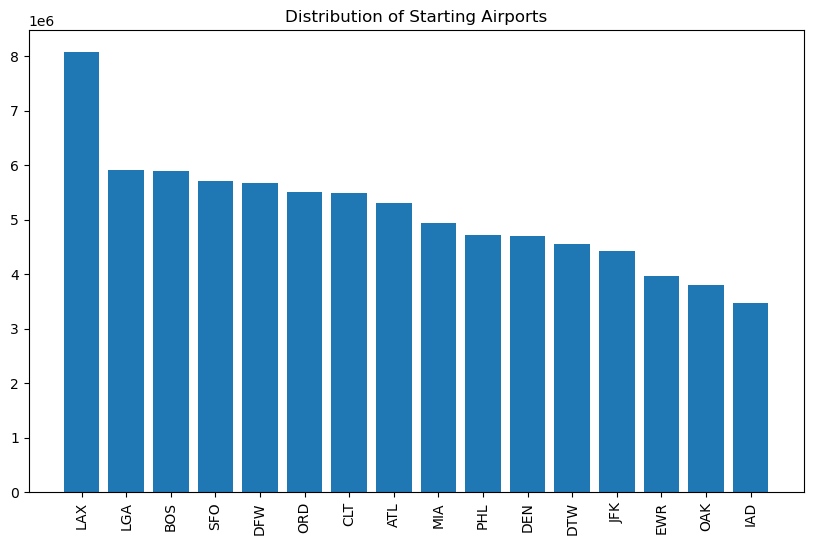

In [24]:
import matplotlib.pyplot as plt

# Convert the DataFrame to Pandas for plotting
starting_airport_dist = sdf.groupBy("startingAirport").count().orderBy("count", ascending=False).toPandas()

# Plot a bar chart for starting airports
plt.figure(figsize=(10,6))
plt.bar(starting_airport_dist['startingAirport'], starting_airport_dist['count'])
plt.xticks(rotation=90)
plt.title('Distribution of Starting Airports')
plt.show()


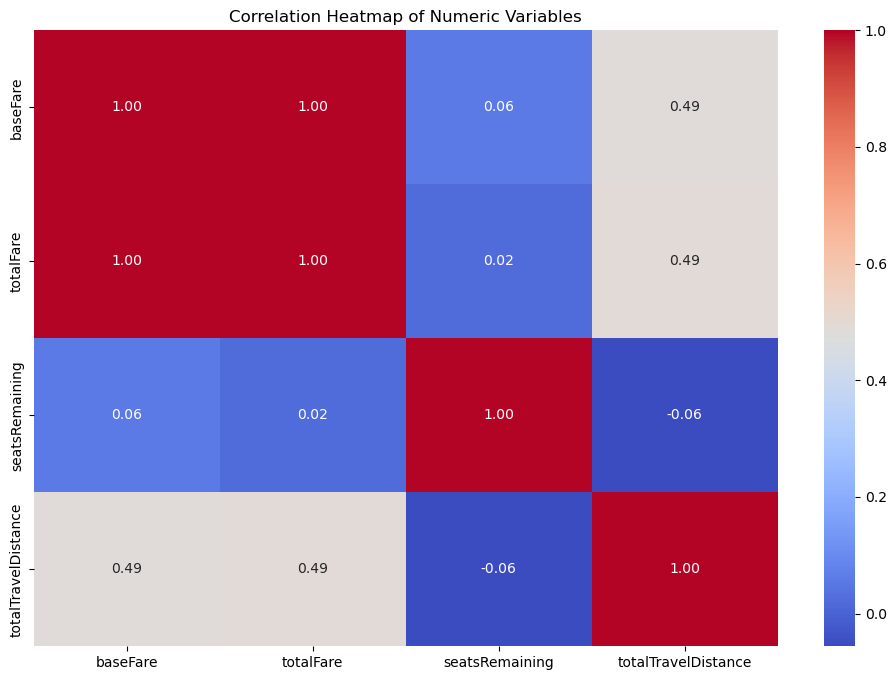

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample a fraction of your data for visualization because file is too big
sampled_sdf = sdf.sample(0.01)

# Calculate the correlation matrix for numeric columns
numeric_columns = [
    "legId", "travelDuration", "baseFare", "totalFare",
    "seatsRemaining", "totalTravelDistance", 
    "segmentsDurationInSeconds", "segmentsDistance"
]
correlation_matrix = sampled_sdf.select(numeric_columns).toPandas().corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()
